<h1>Imports</h1>

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from batch_generator import BatchGenerator
from neural_network import NeuralNetwork

<h1>Model</h1>

In [2]:
batch_size = 20
epochs = 5

nn = NeuralNetwork([784,40,10], BatchGenerator(batch_size))

<h1>Training</h1>

In [3]:
print("training...")
accuracy = []
for epoch in range(epochs):
    nn.train()
    accuracy.append(accuracy_score(*nn.validation()))
print("done")

training...
done


<h1>Validation Results</h1>

[0.90659999999999996, 0.92730000000000001, 0.93979999999999997, 0.9476, 0.9526]


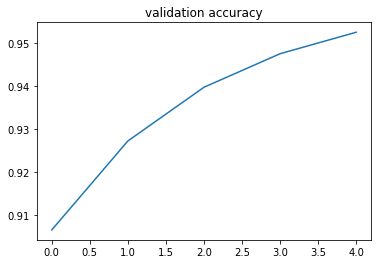

In [4]:
plt.title('validation accuracy')
print(accuracy)
plt.plot(accuracy)
plt.show()

<h1>Testing Results</h1>

In [5]:
test_evaluation = nn.test()
print(confusion_matrix(*test_evaluation))
print()
print(classification_report(*test_evaluation))

[[ 963    0    7    1    1   11    8    3    4    8]
 [   0 1117    2    1    2    2    3   15    9   10]
 [   1    4  976   11    6    2    2   17    5    0]
 [   4    2    8  967    0   26    2    5   18   11]
 [   0    0   11    0  936    4    6    8    8   24]
 [   4    3    0   13    0  819   12    1   15    5]
 [   5    2    7    1    8    9  920    0   13    1]
 [   1    0    9    7    1    3    0  960    7    6]
 [   2    7   11    7    2    8    5    0  891    5]
 [   0    0    1    2   26    8    0   19    4  939]]

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      1006
          1       0.98      0.96      0.97      1161
          2       0.95      0.95      0.95      1024
          3       0.96      0.93      0.94      1043
          4       0.95      0.94      0.95       997
          5       0.92      0.94      0.93       872
          6       0.96      0.95      0.96       966
          7       0.93      0.97      0.95 